In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_, select

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
demo = Base.classes.measurement
demo.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 1a23f567990>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1a23f5679e8>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1a23f567b48>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1a23f567bf8>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1a23f567ca8>,
              'tobs': <sqlalc

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime as dt

from sqlalchemy import desc
query=session.query(Measurement).order_by(desc(Measurement.date)).limit(1)

df = pd.read_sql(query.statement, query.session.bind)
df.head()

lastDate = df.iloc[0]['date']
print(lastDate)

2017-08-23


In [12]:
# Calculate the date 1 year ago from the last data point in the database
ySplit = lastDate.split('-')

print(ySplit)
fDate=int(ySplit[0]) - 1
fDay=int(ySplit[1])-1
print(fDay)
fDate=str(fDate)
print(fDate)
fDate1= fDate+"-0"+str(fDay)+"-"+str(ySplit[2])
print(fDate1)

['2017', '08', '23']
7
2016
2016-07-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
yQuery=session.query(Measurement).filter(and_(Measurement.date >= fDate1, Measurement.date <= lastDate)).order_by(desc(Measurement.date))
yQuery

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(yQuery.statement, yQuery.session.bind)
df.head()
# Sort the dataframe by date

,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


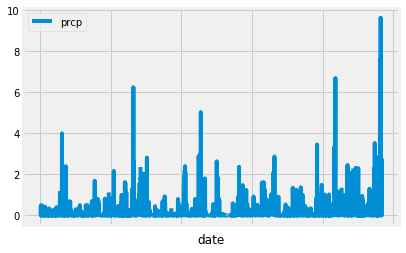

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
dfDP=pd.DataFrame(df,columns=['date', 'prcp'])
dfDP.set_index('date', inplace=True)

dfDP.plot()
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dfDP.describe()

,prcp
count,2195.000000
mean,0.196907
std,0.556862
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [17]:
# Design a query to show how many stations are available in this dataset?
query=session.query(Station)

print(query)

SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sQuery=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).all()

print(sQuery)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

In [20]:
station = sQuery[0][0]
print(station)
sCalc=session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
.filter(Measurement.station == station)
df=pd.read_sql(sCalc.statement, sCalc.session.bind)
df

USC00519281


,station,min_1,max_1,avg_1
0,USC00519281,54.0,85.0,71.663781


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempHighQ=session.query(Measurement.station,func.count(Measurement.tobs).label("Count")).\
group_by(Measurement.station).order_by(desc("Count"))
df=pd.read_sql(tempHighQ.statement, tempHighQ.session.bind)
df

,station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [24]:
tHighStation = df.iloc[0]['station']
fDateQsplit=fDate1.split("-")
fDateQD=str(fDateQsplit[0])+"-0"+str(int(fDateQsplit[1])+2)+"-01"

fDateQ=session.query(Measurement).filter(Measurement.date >= fDate1, Measurement.date <= lastDate, Measurement.station== tHighStation)\
.order_by(desc(Measurement.date))
df=pd.read_sql(fDateQ.statement, fDateQ.session.bind)
df.head()

,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.0,81.0
1,2723,USC00519397,2017-08-22,0.0,82.0
2,2722,USC00519397,2017-08-21,0.0,81.0
3,2721,USC00519397,2017-08-20,0.0,81.0
4,2720,USC00519397,2017-08-19,0.0,79.0


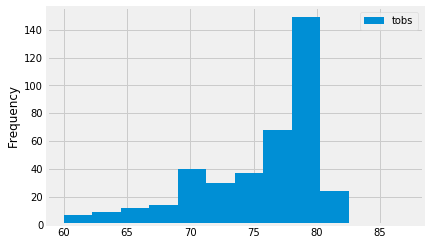

In [25]:
plotDf=pd.DataFrame(df,columns=['date','tobs'])
plotDf.plot.hist(bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
